In [3]:

import mlflow
import mlflow.tensorflow
from dust_extinction.parameter_averages import CCM89
import astropy.units as u

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d
import glob
from scipy import interpolate

fig_path = "/data/kirg/MMVAE/MLFlow"


In [4]:
from tensorflow.python.client import device_lib

devices = device_lib.list_local_devices()
for device in devices:
    if device.device_type == 'GPU':
        print(device)

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22140485632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18128600879403219230
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419



I0000 00:00:1749489132.990904  232600 gpu_device.cc:2019] Created device /device:GPU:0 with 21114 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
mlflow.set_tracking_uri("file:/data/kirg/MMVAE/MLFlow/mlruns")

mlflow.set_experiment("mmvae_pegase")

mlflow.start_run(nested=True)

beta = 1e-3
epochs = 50
latent_dim = 32

mlflow.log_param("beta", beta)
mlflow.log_param("epochs", epochs)
mlflow.log_param("latent_dim", latent_dim)


def fetch_filter_data(filters):
    filter_dict = {}

    for name, filepath in filters:
        try:
            with open(filepath, 'r') as file:
                wavelength, transmission = [], []

                for line in file:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        try:
                            wavelength.append(float(parts[0]))
                            transmission.append(float(parts[1]))
                        except ValueError:
                            continue  # Skip malformed lines

                filter_dict[name] = {
                    "wl": wavelength,
                    "tr": transmission
                }
        except FileNotFoundError:
            print(f"File not found for {name}: {filepath}")
        except Exception as e:
            print(f"Error reading file for {name}: {e}")

    return filter_dict

# Example local filter file paths
filters = [
    ['HSCg', 'HSC_bands/HSC.g_filter.dat'],
    ['HSCr', 'HSC_bands/HSC.r_filter.dat'],
    ['HSCi', 'HSC_bands/HSC.i_filter.dat'],
    ['HSCz', 'HSC_bands/HSC.z_filter.dat'],
    ['HSCY', 'HSC_bands/HSC.Y_filter.dat']
]

filer_names = [name for name, _ in filters]

filter_data = fetch_filter_data(filters)




In [6]:

spec_points = 100
spec_range = (3900, 10200)

def bin_spectrum(spec, wl, spec_range, spec_points):
    min_wl, max_wl = spec_range
    bins = np.linspace(min_wl, max_wl, spec_points + 1)
    mean_values = []
    wl_values = []

    for i in range(len(bins) - 1):
        bin_mask = (wl >= bins[i]) & (wl < bins[i+1])
        bin_data = spec[bin_mask]
        mean_values.append(bin_data.mean() if bin_data.size > 0 else (bins[i] + bins[i+1]) / 2)
        wl_values.append(0.5*(bins[i] + bins[i+1]))
    return np.array(mean_values), np.array(wl_values)


def get_waves(hdr):
     waves = hdr['CRVAL1'] - (hdr['CRPIX1']-1.0)*hdr['CDELT1'] + ( np.arange(0., hdr['NAXIS1']) ) * hdr['CDELT1']
     ran = [waves[0], waves[-1]]
     return waves



def read_fits_files(directory):
    # Define the file pattern to match
    file_pattern = os.path.join(directory, "SB_?_Kroupa_0.1_120_LR.fits")
    fits_files = glob.glob(file_pattern)

    all_spectra = []
    all_params = []

    for fits_file in fits_files:
        with fits.open(fits_file) as hdul:
            spectra = hdul[0].data  # Extracting spectral data
            params = hdul[1].data  # Extracting table data
            wl = get_waves(hdul[0].header)
            all_spectra.extend(spectra*wl**2)
            all_params.append(np.array([tuple(row) for row in params]))  # Ensure structured array consistency

    # Stack spectra along a new axis if necessary (e.g., assuming same dimensions)
    stacked_spectra = np.array(all_spectra)  # Convert list to numpy array

    # Convert list of structured arrays into a single structured array
    structured_params = np.concatenate(all_params) if all_params else None

    # Create an Astropy Table
    result_table = Table(rows=structured_params, names=params.names)

    wl = get_waves(hdul[0].header)
    return stacked_spectra, result_table, wl

In [7]:
def read_fits_files(pattern="SB_*_Kroupa_0.1_120_LR.fits"):
    """Reads FITS files and constructs a 3D spectral array."""

    files = sorted(glob.glob(pattern))  # Get all relevant FITS files
    if not files:
        raise FileNotFoundError("No FITS files found matching pattern.")

    spectra_list = []
    ages = []
    mets = []

    for file in files:
        with fits.open(file) as hdul:
            primary_data = hdul[0].data  # Spectra
            params = hdul["ETS_PARA"].data  # Age & metallicity
            wl = hdul[3].data['BFIT']  # Wavelengths
            primary_data = np.array([fl*wl**2 for fl in primary_data])
            age = params["AGE"]  # Extract age
            met = params["ZSTARS"]  # Extract metallicity
            spectra_list.append(primary_data[age > 100])
            ages.append(np.log10(age)[age > 100])
            mets.append(np.round(np.log10(met/0.02), 2)[age > 100])

    spectra_array = np.stack(spectra_list, axis=1)  # Convert list to 3D array

    # Convert age and metallicity into logarithmic scales divided by 0.2
    lages = np.array(ages)
    lmets = np.array(mets)

    return lages, lmets, spectra_array, wl


class SpectrumInterpolator:
    def __init__(self, lages, lmets, flx):
        """Initialize with log(age), log(metallicity), and flux array."""
        self.lages = np.unique(lages)  # Ensure uniqueness
        self.mets = np.unique(lmets)
        self.flx = flx
        print(self.lages.shape, self.mets, flx[:, :, 0].shape)
        # Create interpolators for each wavelength slice
        self.interpolators = [
            interpolate.RectBivariateSpline(self.lages, self.mets, flx[:, :, i])
            for i in range(flx.shape[2])
        ]

    def evaluate(self, age, metallicity):
        """Evaluate spectrum at arbitrary log(age) and log(metallicity)."""
        log_age = np.log10(age)
        log_met = metallicity

        return np.array([interp(log_age, log_met)[0, 0] for interp in self.interpolators])

# Usage Example
lages, lmets, flx, wl = read_fits_files('newgrid2_lr_kroupa/SB_*_Kroupa_0.1_120_LR.fits')
spectrum_interp = SpectrumInterpolator(lages, lmets, flx)

# Evaluate spectrum at specific age and metallicity
age_sample = 1100  # Example age (5 Gyr)
met_sample = -0.50  # Example metallicity

#def calc_spec(wl, age = 1000, met = 0.00, z=0.0):
#    spec = spectrum_interp.evaluate(age, met)
#    return (spec, wl*(1 + z))




def calc_spec(wl, age=1000, met=0.00, z=0.0, Av=0.0, Rv=3.1):
    # Ensure wl is a numpy array
    wl = np.asarray(wl)

    # Interpolate the spectrum for the given age and metallicity
    spec = spectrum_interp.evaluate(age, met)

    # Apply redshift to the wavelength
    wl_z = wl * (1 + z)

    # Convert wl_z from Angstroms to microns
    wl_z_micron = wl_z * 1e-4  # because 1 Angstrom = 1e-4 micron
    wl_z_q = wl_z_micron * u.micron  # now attach astropy unit

    # Apply extinction if Av > 0
    if Av > 0:
        ext_model = CCM89(Rv=Rv)
        inp_ext = 1.0 / wl_z_q
        inp_ext[inp_ext.value < 0.3] = 0.3 / u.micron
        inp_ext[inp_ext.value > 10] = 10.0 / u.micron

        extinction = ext_model(inp_ext) * Av  # extinction in magnitudes
        attenuation = 10 ** (-0.4 * extinction)  # .value gives plain numbers
        spec *= attenuation

    return spec, wl_z

(22,) [-2.5 -2.  -1.5 -1.  -0.5 -0.3  0.   0.3  0.5  1. ] (22, 10)


In [8]:
def download_filter_curve(url):
    """Download and parse the filter transmission curve from a given URL."""
    response = requests.get(url)
    response.raise_for_status()
    data = np.loadtxt(response.iter_lines())
    return data[:, 0], data[:, 1]  # wavelengths, transmissions

def calculate_flux_and_mag(spectra_list, wavelengths_list, filters):
    """Calculate the flux and AB magnitude for multiple spectra and filters."""
    all_results = []
    all_speclr = []
    all_wllr = []

    for spectra, wavelengths in zip(spectra_list, wavelengths_list):
        results = []
        speclr, wllr = bin_spectrum(spectra, wavelengths, spec_range, spec_points)
        for filter_name, filter_url in filters:
            #filter_wavelengths, transmissions = download_filter_curve(filter_url)
            fd = filter_data[filter_name]
            filter_wavelengths, transmissions = fd['wl'], fd['tr']
            # Interpolate spectra onto the filter transmission wavelengths
            interp_flux = interp1d(wavelengths, spectra, kind='linear', fill_value=0, bounds_error=False)
            flux_interp = interp_flux(filter_wavelengths)
            filter_wavelengths = np.array(filter_wavelengths)
            # Calculate total flux (assuming simple integration)
            total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
            total_flux /= np.trapz(transmissions, filter_wavelengths)
            #total_flux /= np.nanmax(total_flux)

            # Calculate AB magnitude
            if total_flux > 0:
                ab_magnitude = -2.5 * np.log10(total_flux) - 48.6  # AB mag formula
            else:
                ab_magnitude = np.inf  # Undefined magnitude for zero flux

            results.append([filter_name, total_flux, ab_magnitude])

        all_results.append(results)
        all_speclr.append(speclr)
        all_wllr.append(wllr)

    return all_results, [all_speclr, all_wllr]

In [9]:
spectra_list = []
wavelengths_list = []

num_samples = 32000  # Adjust as needed
z_vals = np.random.uniform(0, 1.00, num_samples)
age_vals = 10**np.random.uniform(np.log10(500), np.log10(15000), num_samples)
metdex_vals = np.random.uniform(-0.50, 0.1, num_samples)

n_young = int(num_samples/10)

age_young_vals = np.random.uniform(500, 2000, n_young)





spectra_list = []
wavelengths_list = []
param_list = []

for z, age, metdex in zip(z_vals, age_vals, metdex_vals):
    gen = calc_spec(wl, age=age, met=metdex, z=z)
    sp = gen[0]
    if ((age > 7000) & (np.random.random() > 1.7)):
        wei = np.random.random()
        age_add = np.random.uniform(100, 1500)
        gen_add = calc_spec(wl, age=age_add, met=metdex, z=z)
        sp = sp * (1 - wei) + gen_add[0] * wei
        age = age * (1 - wei) + age_add * wei
    if ((age < 3000) & (np.random.random() > 0.5)):
        gen = calc_spec(wl, age=age, met=metdex, z=z, Av=10**np.random.uniform(np.log10(0.01), np.log10(0.5)))
        sp = gen[0]
    sp = sp / np.max(sp)
    spectra_list.append(sp)
    wavelengths_list.append(gen[1])
    param_list.append([z, age, metdex])  # Store the corresponding parameters




print(len(spectra_list))
print(len(wavelengths_list))

mags, lr = calculate_flux_and_mag(spectra_list, wavelengths_list, filters)
output_array = [[[entry[1] for entry in mag_entry], params, speclr] for mag_entry, params, speclr in zip(mags, param_list, lr[0])]

output_array = [[[float(val) for val in flux_list], [float(params[0]), float(params[1]), params[2]], lr] for flux_list, params, lr in output_array]

print(len(output_array))

N_smpl = 20  # Number of realizations per entry

# Create new array with perturbations
dataset_rnd = []

for flux_list, params, lr in output_array:
    sig = [0.01 for _ in range(5)]
    for _ in range(N_smpl):
        flux_list /= np.max(flux_list)
        perturbed_flux = [val + sig[sigi] * np.random.normal(0, 1) * val for sigi,val in enumerate(flux_list)]  # Add perturbation
        dataset_rnd.append([perturbed_flux, params, lr])  # Duplicate params as required


integrals = np.array([entry[0] for entry in dataset_rnd])  # 2D array of flux values
params = np.array([entry[1] for entry in dataset_rnd])  # 2D array of corresponding parameters
params[:, 1] /= 1e4
spectra = np.array([entry[2] / np.max(entry[2]) for entry in dataset_rnd])  # 2D array of corresponding parameters


32000
32000


/tmp/ipykernel_232600/1321028791.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux = np.trapz(flux_interp * transmissions, filter_wavelengths)
/tmp/ipykernel_232600/1321028791.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_flux /= np.trapz(transmissions, filter_wavelengths)


32000


In [10]:
output_array = [[[float(val) for val in flux_list], [float(params[0]), float(params[1]), params[2]], lr] for flux_list, params, lr in output_array]

print(integrals[0])

[0.09477536 0.36257874 0.63497609 0.80546475 1.00431126]


In [11]:
class Sampling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon


def build_dense_encoder_sed_branch(input_shape):
    dense_input = keras.Input(shape=input_shape)
#    x = layers.Dense(64, activation='relu')(dense_input)
#    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(dense_input)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    return keras.Model(dense_input, x, name='dense_encoder_branch')

def build_dense_decoder_sed(latent_dim, output_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name=f'z_sampling')
    x = layers.Dense(32, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(16, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return keras.Model(latent_inputs, outputs, name='dense_decoder')

def build_encoder_sp_branch(input_shape):
    cnn_input = keras.Input(shape=input_shape)
    #x = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(cnn_input)
    #x = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(cnn_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    return keras.Model(cnn_input, x, name='cnn_encoder')

def build_dense_decoder_sp(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(32, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)
    #outputs = layers.Reshape(output_dim)(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()


def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
     

class SpectraVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_encoder_sp_branch((input_dim,1))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='cnn_encoder')

        self.decoder = build_dense_decoder_sp(latent_dim,(input_dim,1))
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        return self.apply(data)[3]



    def train_step(self, data):
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        (z_mean, z_log_var, z, reconstruction) = self.apply(data)
        reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
     


[ 0.41982085  0.15246129 -0.47774625]


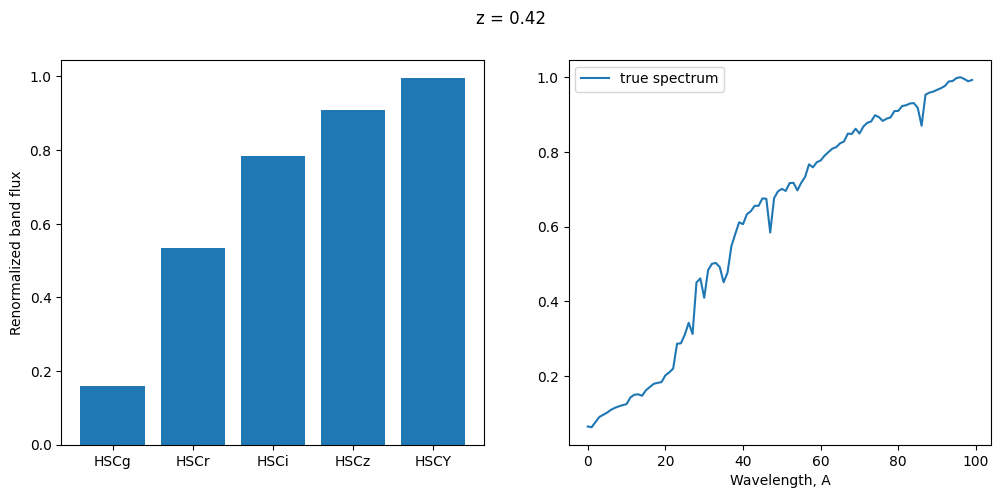

[ 0.41982085  0.15246129 -0.47774625]


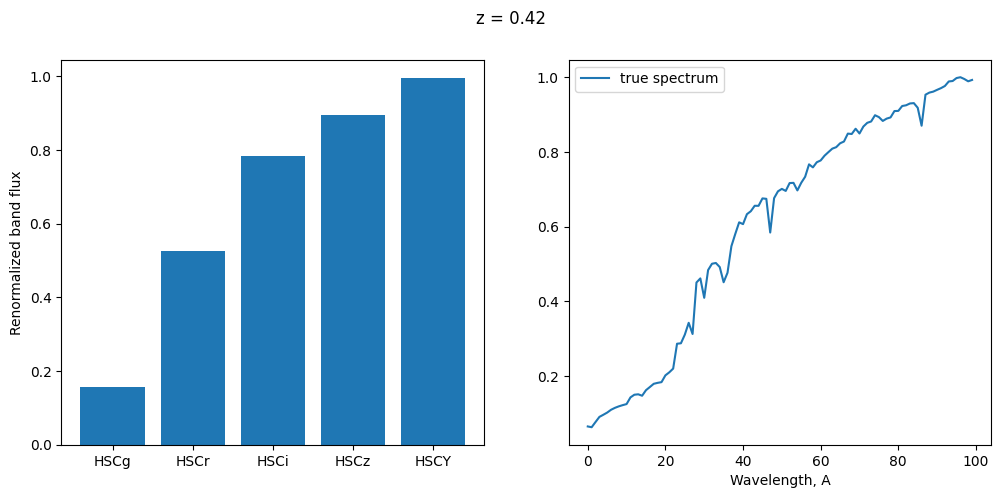

[ 0.41982085  0.15246129 -0.47774625]


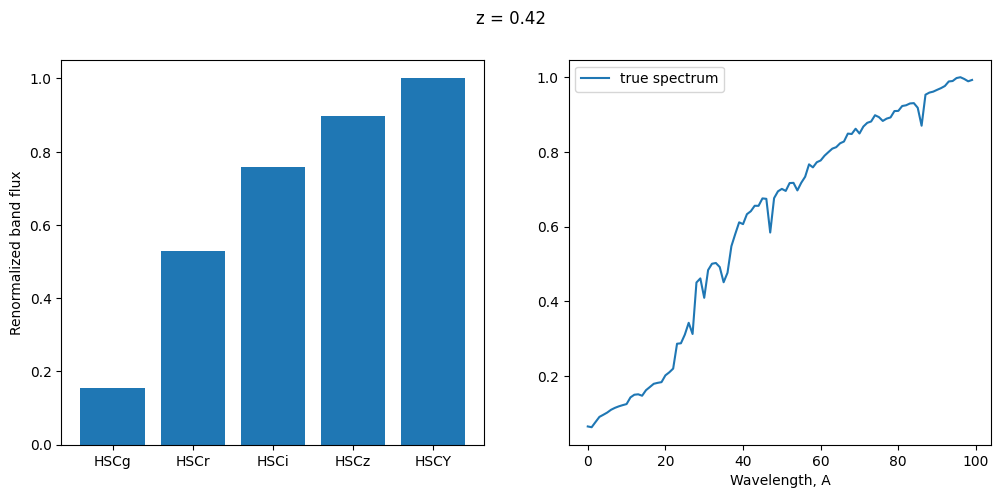

[ 0.41982085  0.15246129 -0.47774625]


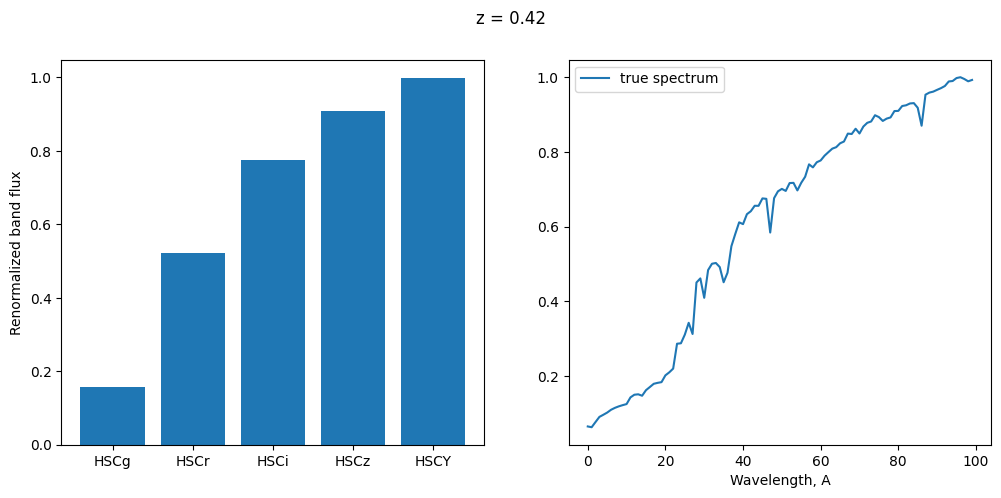

[ 0.41982085  0.15246129 -0.47774625]


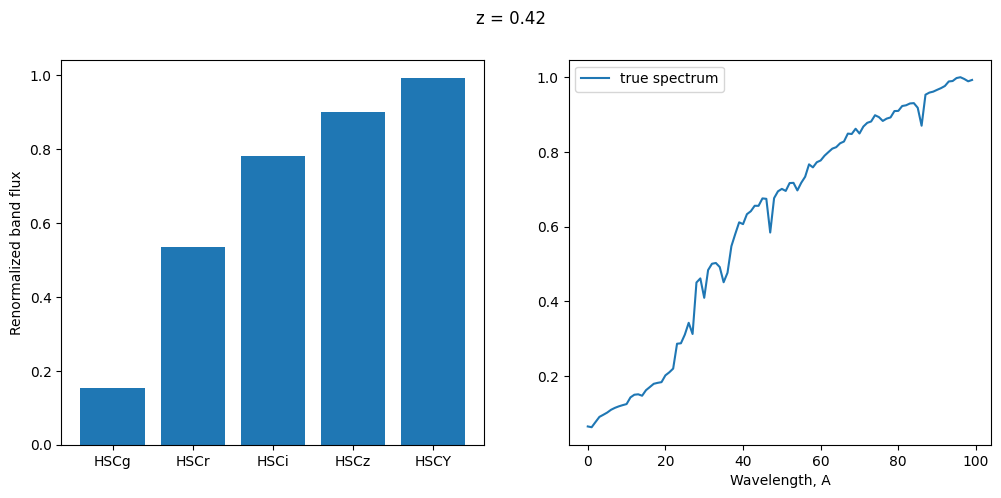

[ 0.41982085  0.15246129 -0.47774625]


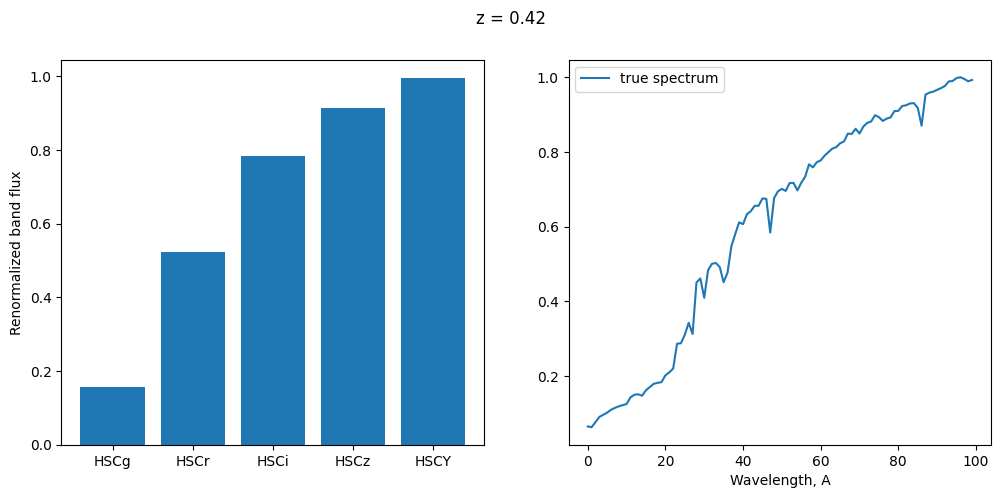

[ 0.41982085  0.15246129 -0.47774625]


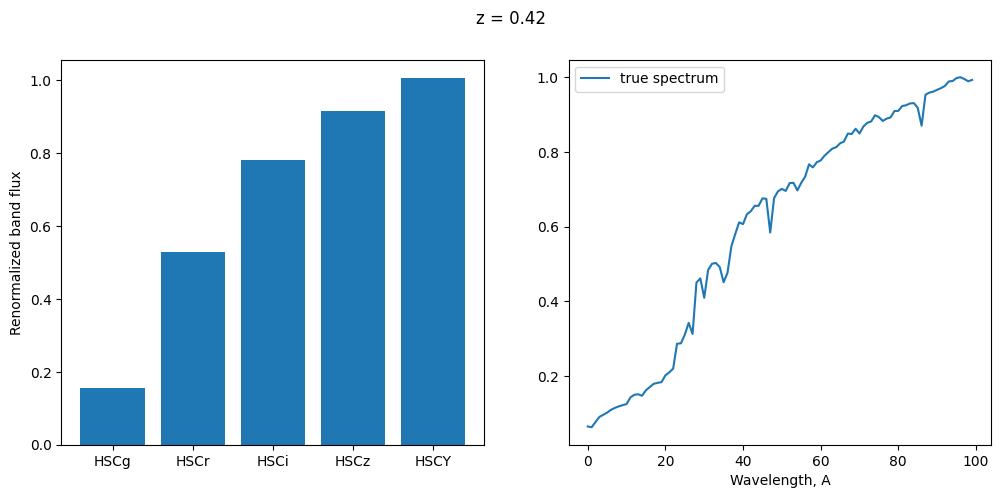

[ 0.41982085  0.15246129 -0.47774625]


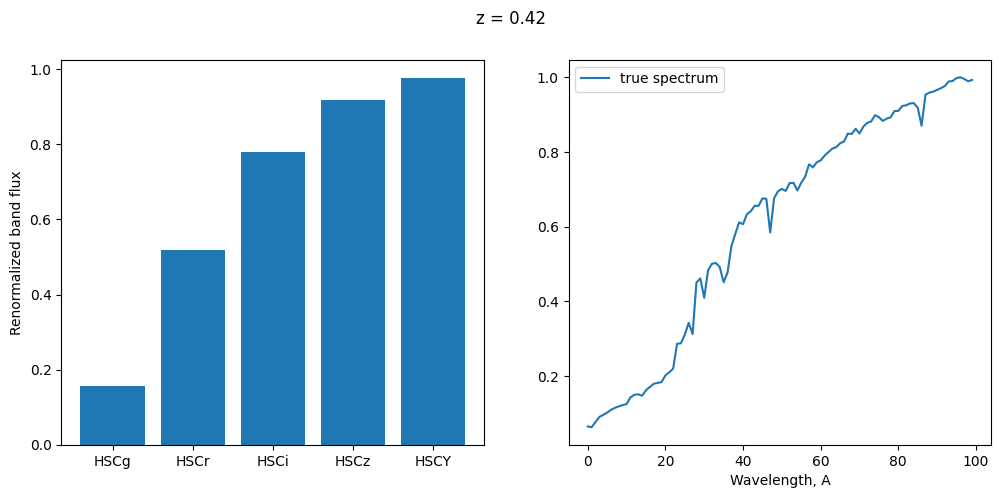

[ 0.41982085  0.15246129 -0.47774625]


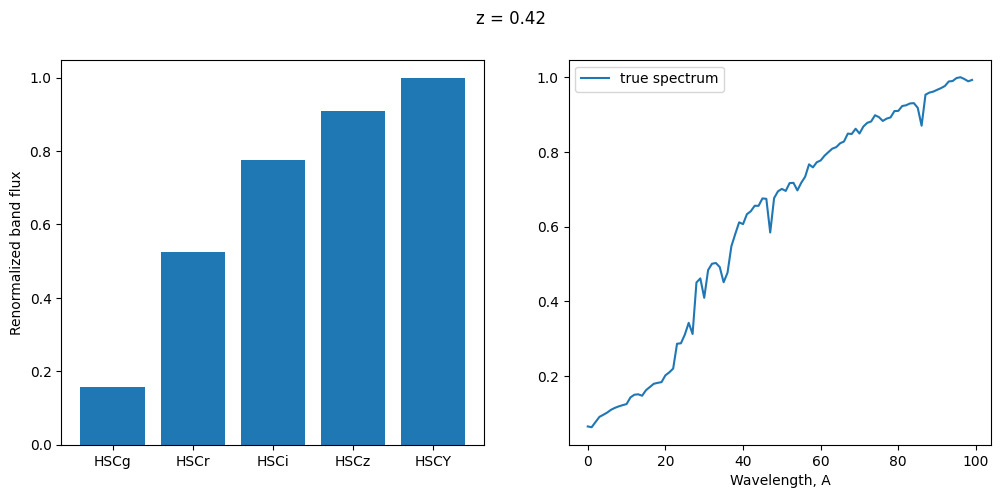

[ 0.41982085  0.15246129 -0.47774625]


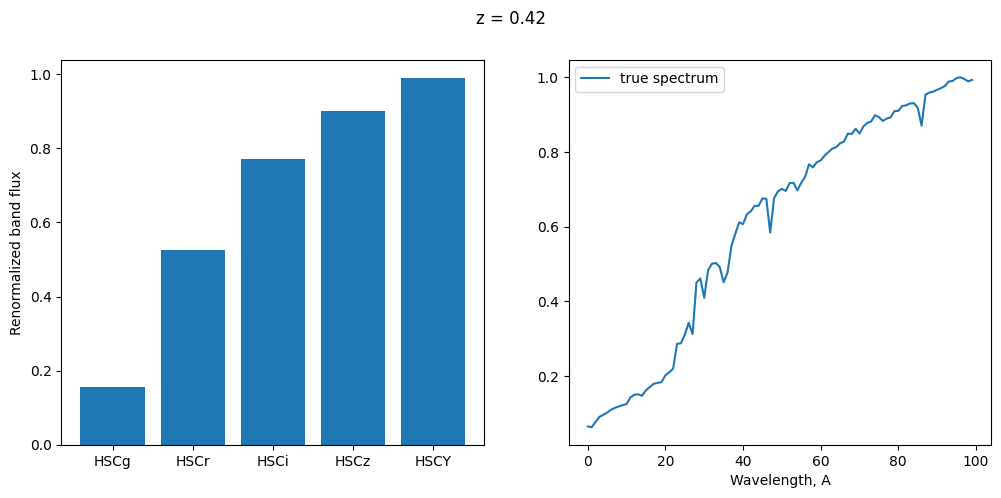

In [12]:
ii=1000
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    print(params[ii])
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [13]:
spvae = SpectraVAE(100, latent_dim, beta=beta)
spvae.compile(optimizer=keras.optimizers.Adam())
hsp=spvae.fit(spectra, epochs=epochs, batch_size=128, validation_split=0.2)

I0000 00:00:1749489224.453673  232600 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21114 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Epoch 1/50


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(128, 100))
  warnings.warn(msg)
I0000 00:00:1749489226.305418  233051 service.cc:152] XLA service 0x7575e00022a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749489226.305431  233051 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2025-06-09 19:13:46.336240: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749489226.581815  233051 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-06-09 19:13:46.933218: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'g

 150/4000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - kl_loss: 28.5398 - loss: 0.5247 - reconstruction_loss: 0.4962

I0000 00:00:1749489233.276234  233051 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - kl_loss: 13.5232 - loss: 0.0622 - reconstruction_loss: 0.0486 - val_kl_loss: 6.0488 - val_loss: 0.0284 - val_reconstruction_loss: 0.0224
Epoch 2/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - kl_loss: 5.8694 - loss: 0.0189 - reconstruction_loss: 0.0130 - val_kl_loss: 5.3884 - val_loss: 0.0173 - val_reconstruction_loss: 0.0119
Epoch 3/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - kl_loss: 5.6485 - loss: 0.0148 - reconstruction_loss: 0.0092 - val_kl_loss: 5.4474 - val_loss: 0.0152 - val_reconstruction_loss: 0.0097
Epoch 4/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - kl_loss: 5.7551 - loss: 0.0136 - reconstruction_loss: 0.0079 - val_kl_loss: 5.7408 - val_loss: 0.0149 - val_reconstruction_loss: 0.0091
Epoch 5/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_loss: 5.8377 - loss: 0.0129 - reconstruction_loss: 0.0071 - val_kl_loss: 5.8460 - val_loss: 0.0144 - val_reconstruction_loss: 0.0085
Epoch 6/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 2m

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)


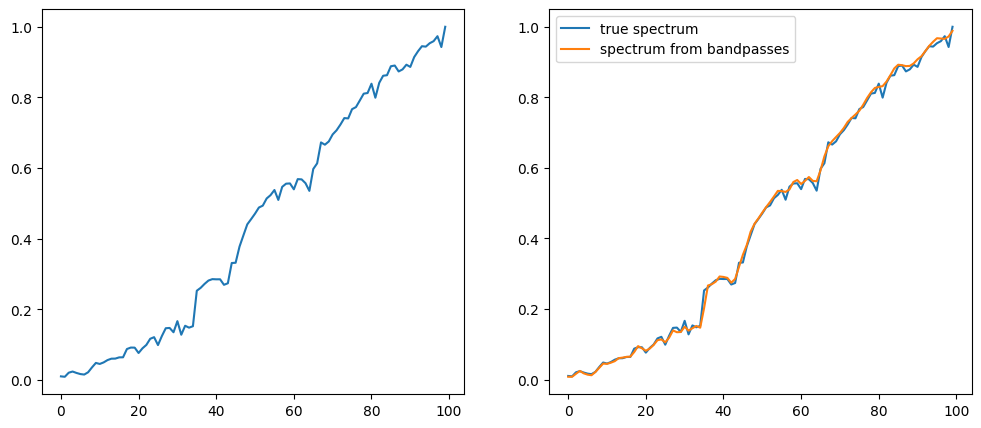

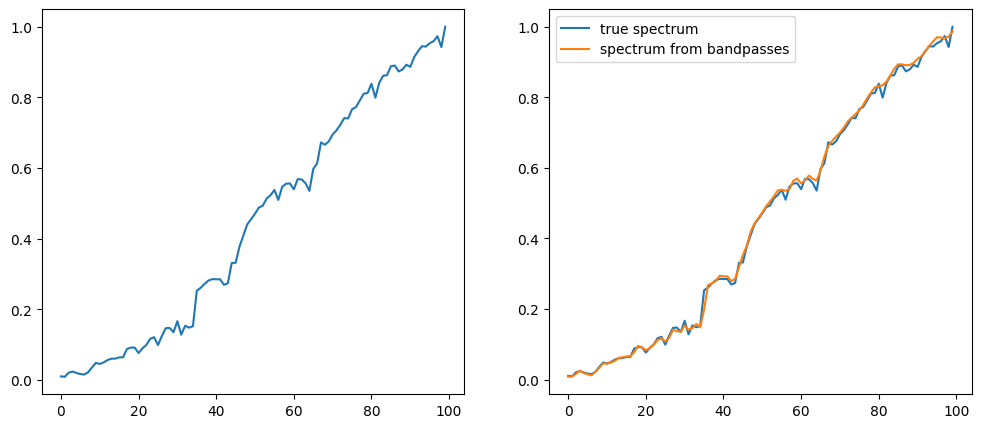

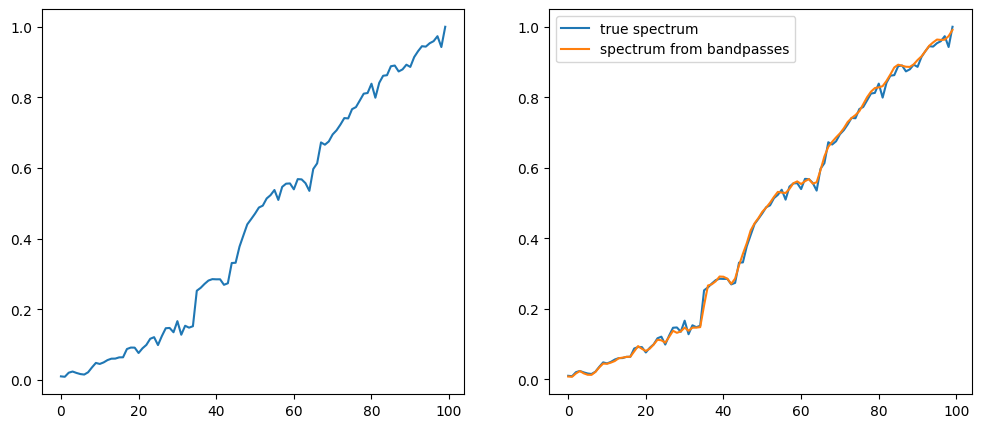

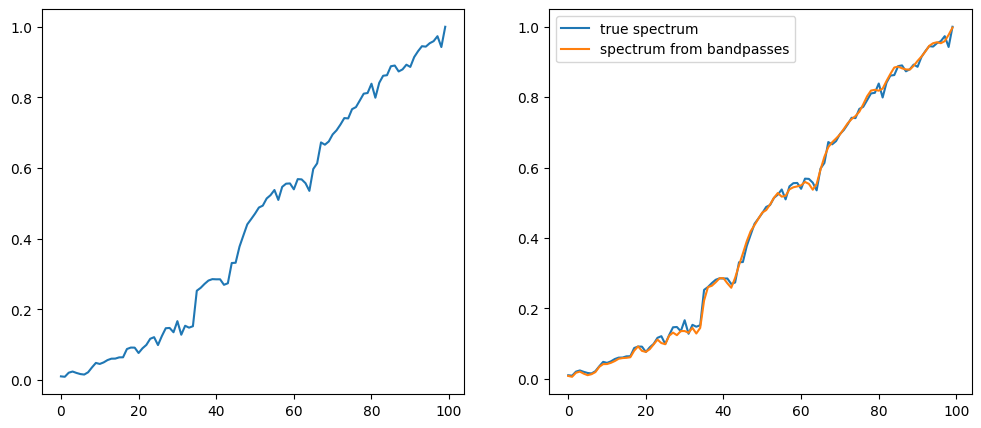

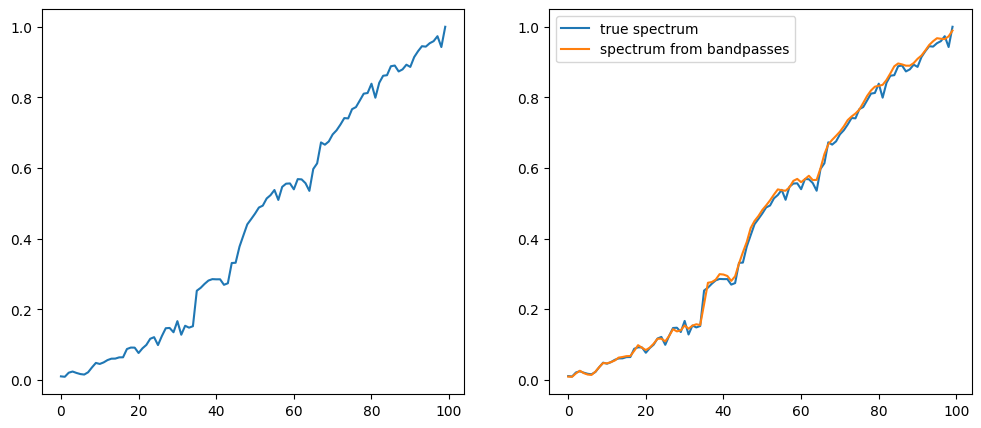

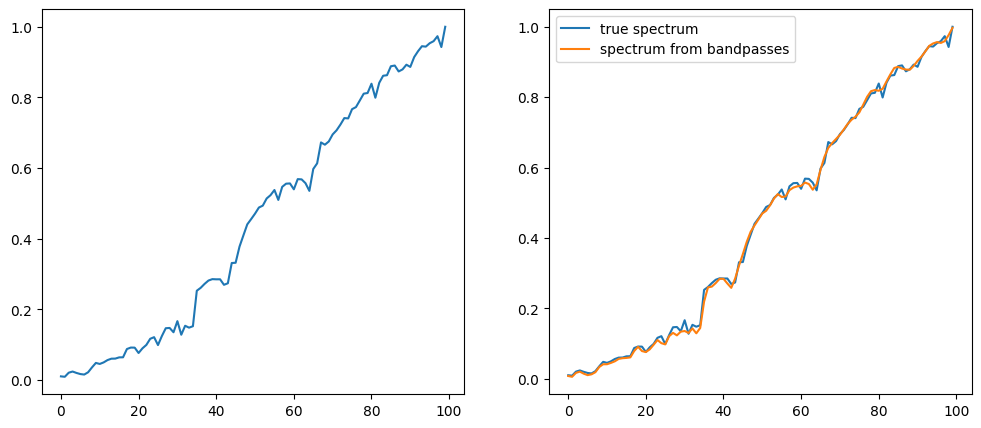

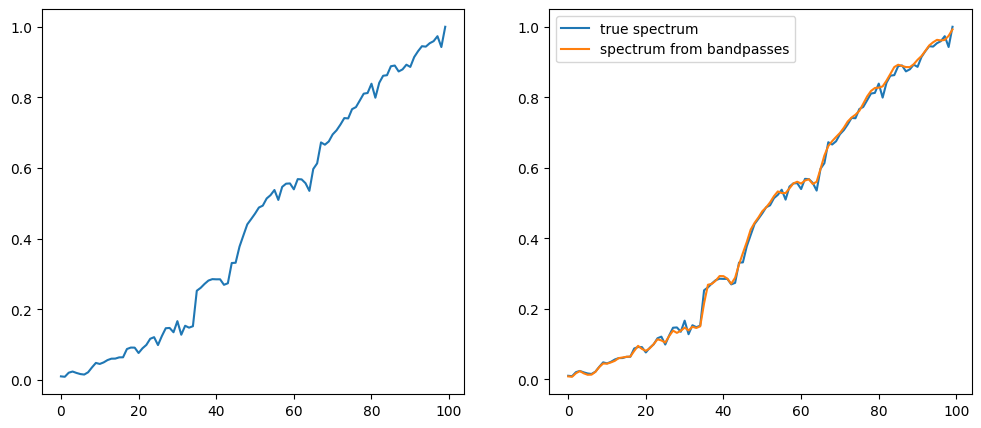

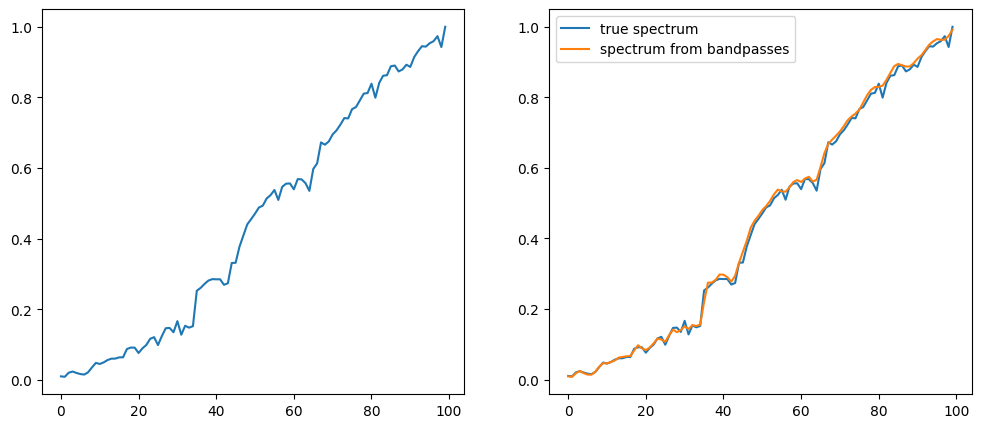

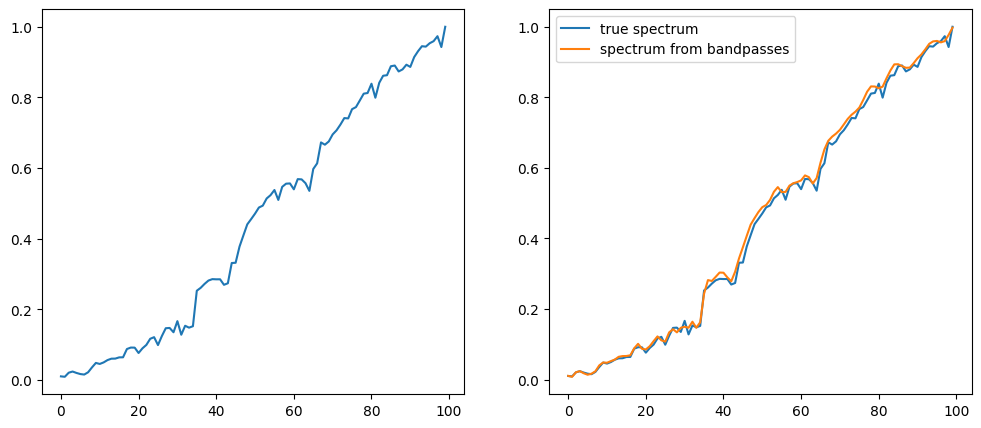

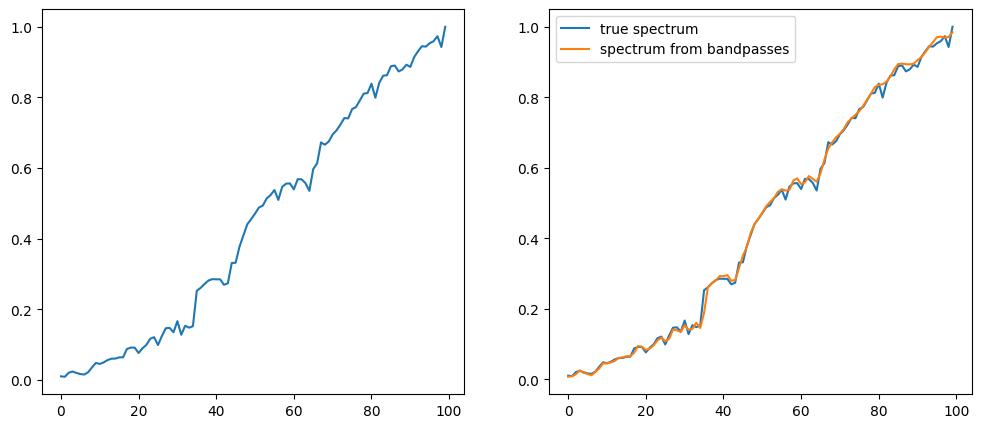

In [14]:
ii=1126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = spvae(np.reshape(spectra[ii], (1,100)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].plot(range(len(spectra[ii])), spectra[ii])
    plt.legend()
    plt.show()

In [15]:
class BandPassVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='dense_encoder')

        self.decoder = spvae.decoder
        self.decoder.trainable = False  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [16]:
bpvae = BandPassVAE(5,latent_dim, beta=beta)
bpvae.compile(optimizer=keras.optimizers.Adam())
h=bpvae.fit((integrals, spectra), epochs=epochs, batch_size=128, validation_split=0.2)


Epoch 1/50


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_17']
Received: inputs=Tensor(shape=(128, 5))
  warnings.warn(msg)


4000/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 5.2321 - loss: 0.1146 - reconstruction_loss: 0.1093((<tf.Tensor 'data:0' shape=(128, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(128, 100) dtype=float32>),)
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - kl_loss: 5.2321 - loss: 0.1146 - reconstruction_loss: 0.1093 - val_kl_loss: 5.9954 - val_loss: 0.0624 - val_reconstruction_loss: 0.0564
Epoch 2/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - kl_loss: 5.5113 - loss: 0.0405 - reconstruction_loss: 0.0349 - val_kl_loss: 6.3633 - val_loss: 0.0645 - val_reconstruction_loss: 0.0581
Epoch 3/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - kl_loss: 5.6790 - loss: 0.0333 - reconstruction_loss: 0.0276 - val_kl_loss: 6.4360 - val_loss: 0.0624 - val_reconstruction_loss: 0.0560
Epoch 4/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_loss: 5.7600 - loss: 0.0277 - reconstruction_loss: 0.0219 - val_kl_loss: 6.3413 - val_loss: 0.0593 - val_reconstruction_loss: 0.0530
Epoch 5/50
4000/4000 ━━━━━━

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_17']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)


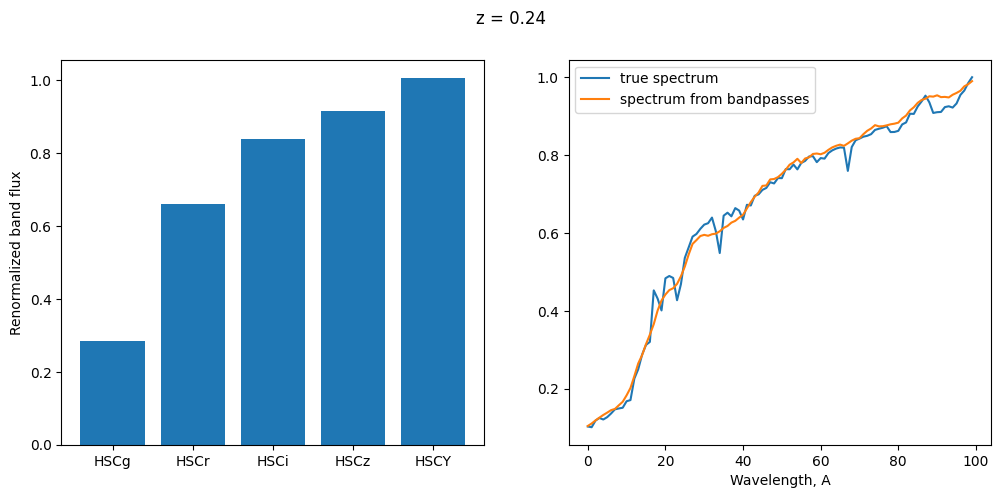

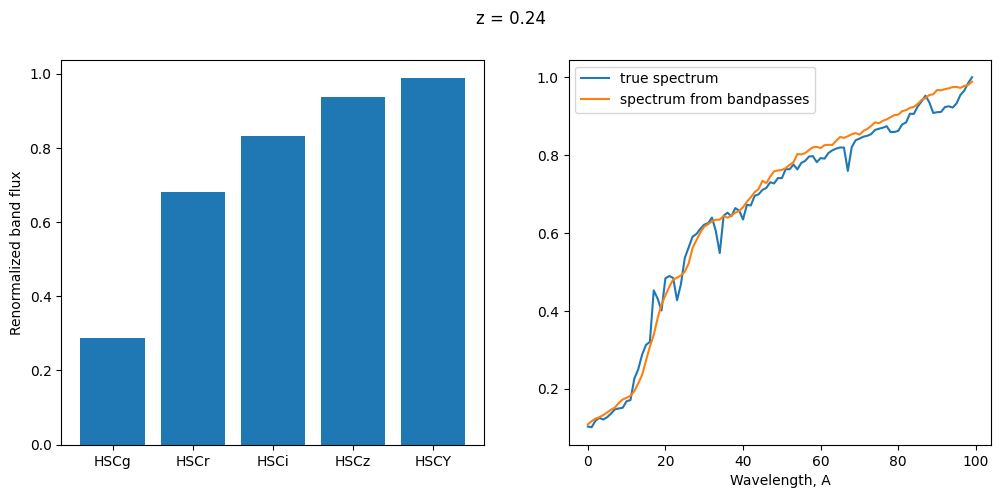

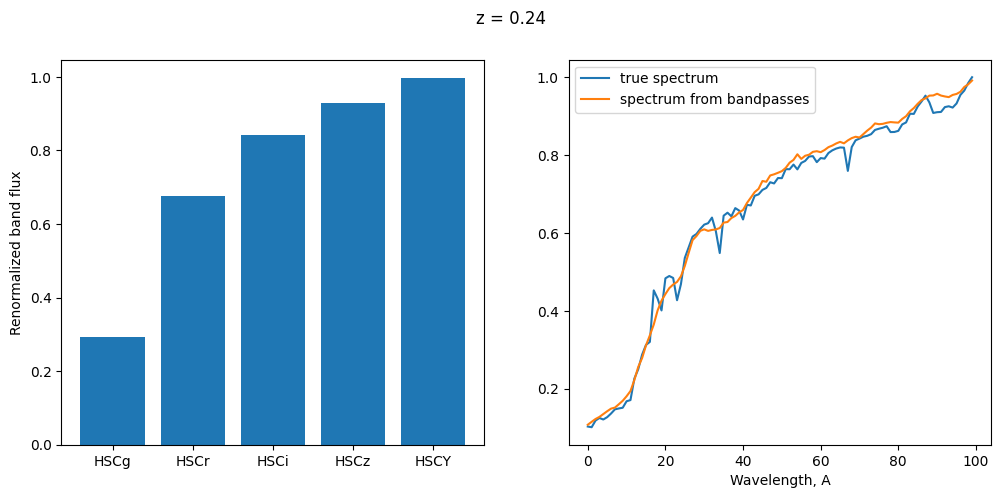

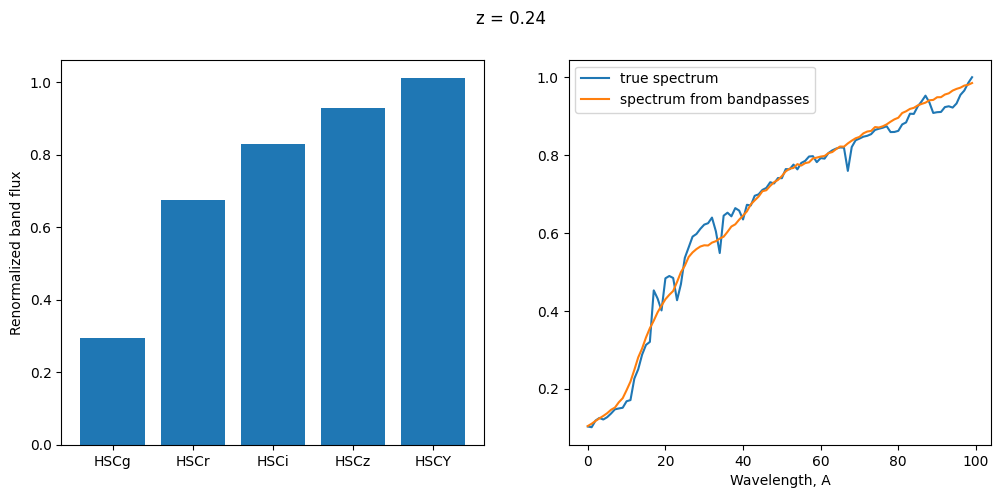

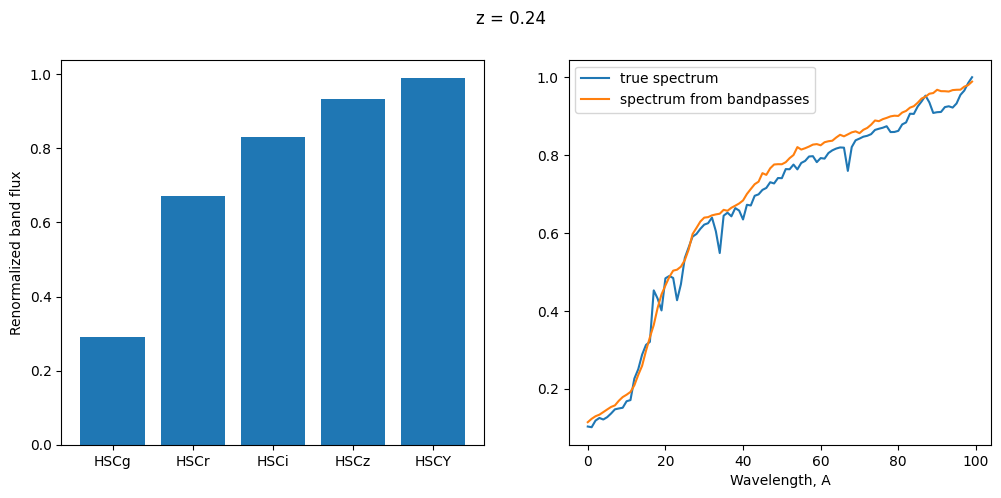

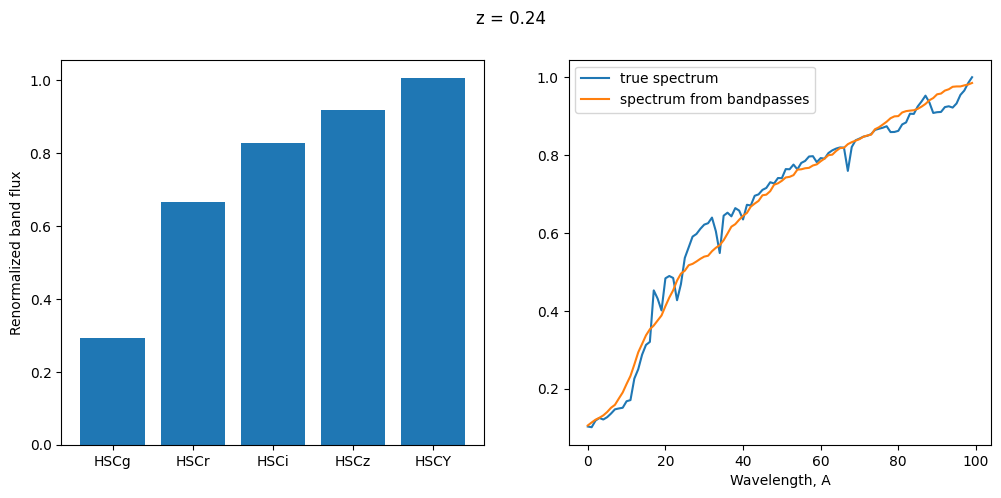

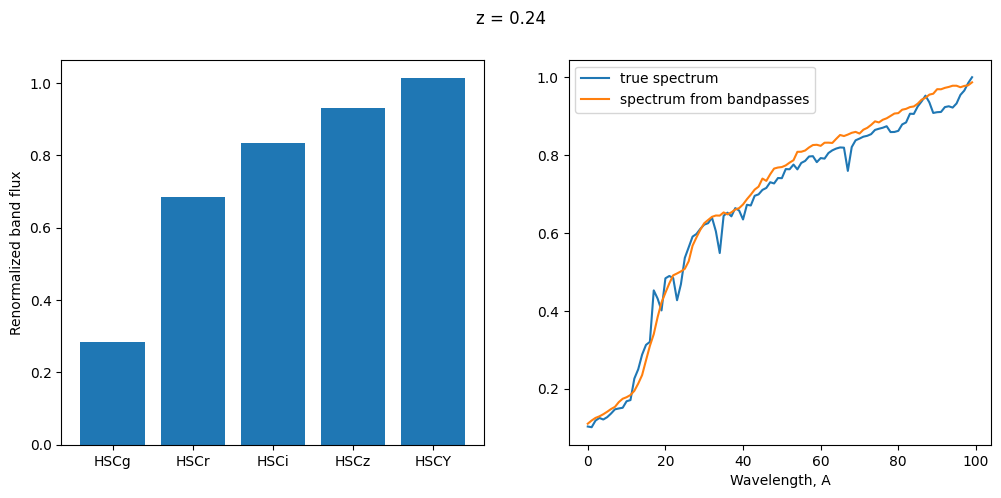

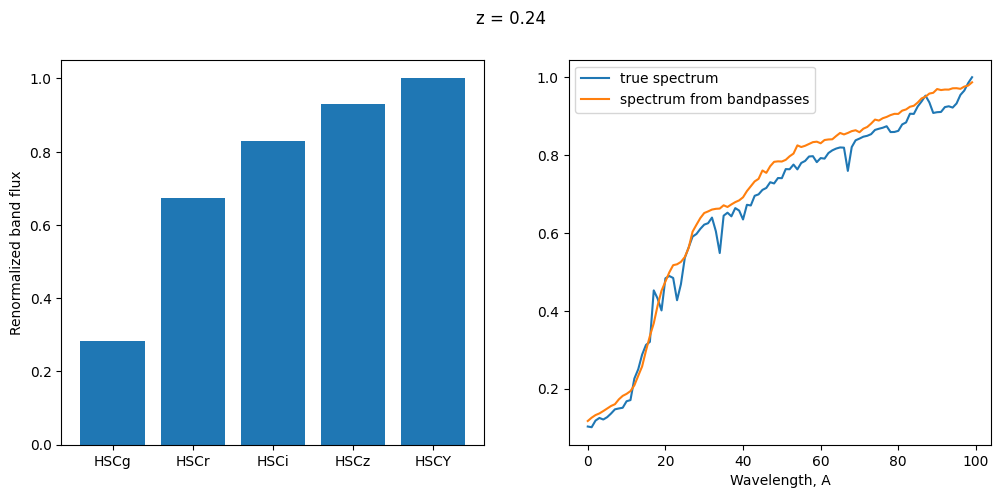

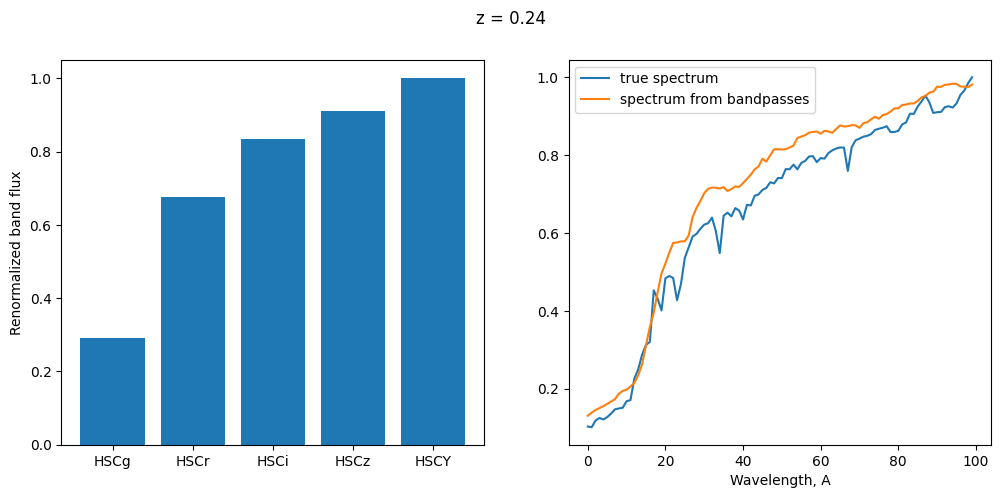

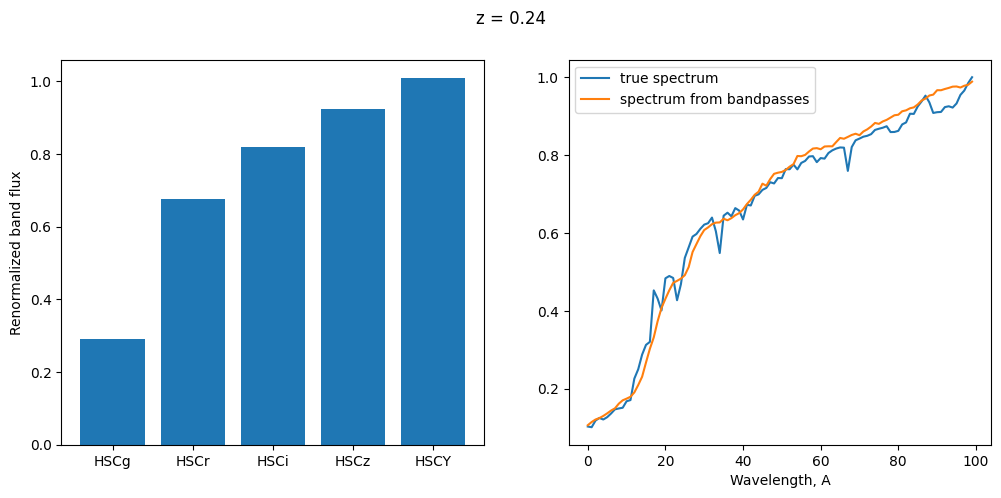

In [17]:
ii=10126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = bpvae(np.reshape(integrals[ii], (1,5)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[1].set_xlabel('Wavelength, A')
    axs[0].bar(filer_names, integrals[ii])
    axs[0].set_ylabel('Renormalized band flux')
    fig.suptitle('z = %.2f' % (params[ii, 0]))
    plt.legend()
    plt.show()

In [52]:
def build_dense_decoder_param(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


class ParamVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = spvae.encoder_branch #build_encoder_sp_branch((input_dim,1))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])
        self.wei = np.array([1, 1, 1])
        self.wei = self.wei / np.sum(self.wei)
        self.encoder = spvae.encoder
        self.encoder.trainable = False  # Prevent training of the decoder

        self.decoder = build_dense_decoder_param(latent_dim,(3,1))
        self.decoder.trainable = True  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    #def call(self, data):
    #    (data_in, data_out) = data[0]
    #    return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.square(data_out*self.wei - reconstruction*self.wei)
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square(data_out*self.wei - reconstruction*self.wei))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [53]:
parvae = ParamVAE(100,latent_dim, beta=beta)
print(parvae.decoder)

parvae.compile(optimizer=keras.optimizers.Adam())
h=parvae.fit((spectra, params), epochs=epochs, batch_size=128, validation_split=0.2)

<Functional name=dense_decoder, built=True>
Epoch 1/50
3989/4000 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 6.2374 - loss: 0.0094 - reconstruction_loss: 0.0032((<tf.Tensor 'data:0' shape=(128, 100) dtype=float32>, <tf.Tensor 'data_1:0' shape=(128, 3) dtype=float32>),)
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - kl_loss: 6.2375 - loss: 0.0094 - reconstruction_loss: 0.0032 - val_kl_loss: 6.4539 - val_loss: 0.0092 - val_reconstruction_loss: 0.0028
Epoch 2/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - kl_loss: 6.2375 - loss: 0.0088 - reconstruction_loss: 0.0026 - val_kl_loss: 6.4539 - val_loss: 0.0093 - val_reconstruction_loss: 0.0028
Epoch 3/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - kl_loss: 6.2375 - loss: 0.0088 - reconstruction_loss: 0.0026 - val_kl_loss: 6.4539 - val_loss: 0.0092 - val_reconstruction_loss: 0.0027
Epoch 4/50
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - kl_loss: 6.2375 - loss: 0.0088 - reconstruction_loss: 0.0026 - val_kl_loss: 6.4539 - val_loss: 0.0092 - val_

In [54]:
class ParamVAEuse(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = spvae.encoder_branch

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])
        self.wei = np.array([1, 1, 1])
        self.wei = self.wei / np.sum(self.wei)
        self.encoder = bpvae.encoder
        self.encoder.trainable = False  # Prevent training of the decoder

        self.decoder = parvae.decoder
        self.decoder.trainable = False  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

parvaeuse = ParamVAEuse(6,latent_dim, beta=beta)

tf.Tensor([ 0.23531109  1.1875367  -0.07369459], shape=(3,), dtype=float32) [0.28852884 1.08825618 0.0020538 ]


<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_232600/1424161353.py:17: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_17']
Received: inputs=Tensor(shape=(80000, 5))
  warnings.warn(msg)


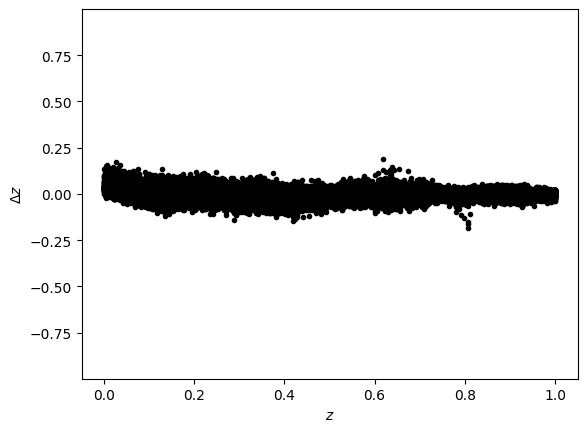

In [55]:
pnames = ['z', 't', '[Z/H]']

s = parvaeuse(np.reshape(integrals[:80000], (80000,5)))
p = params[:80000]

res = s - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\D'
<>:6: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_232600/325034530.py:6: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')


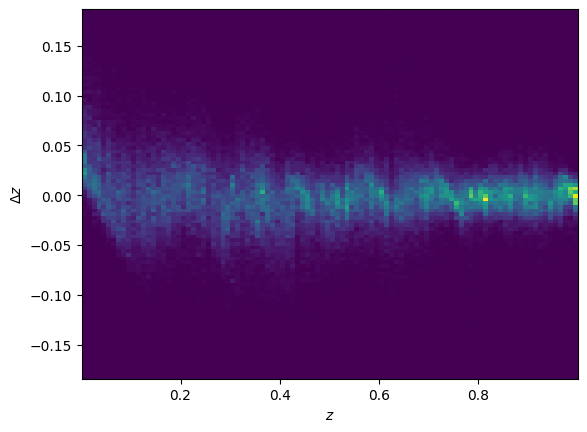

In [56]:
plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.hist2d(plx, ply, bins=100)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

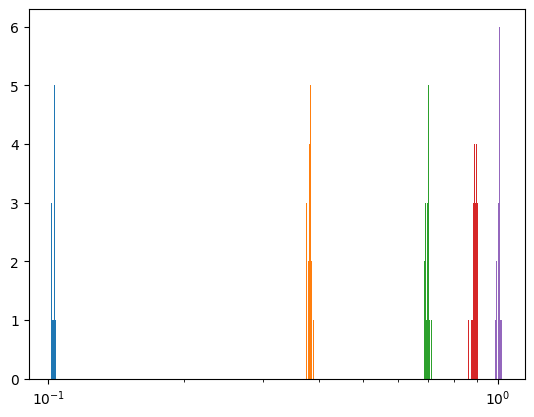

In [57]:
idx_sel = np.where(params[:,0] == params[200000, 0])[0]

for i in range(0, 5):
    plt.hist(integrals[idx_sel][:,i])

plt.xscale('log')
plt.show()

<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
<>:9: SyntaxWarning: invalid escape sequence '\D'
<>:17: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_232600/582374311.py:9: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
/tmp/ipykernel_232600/582374311.py:17: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')


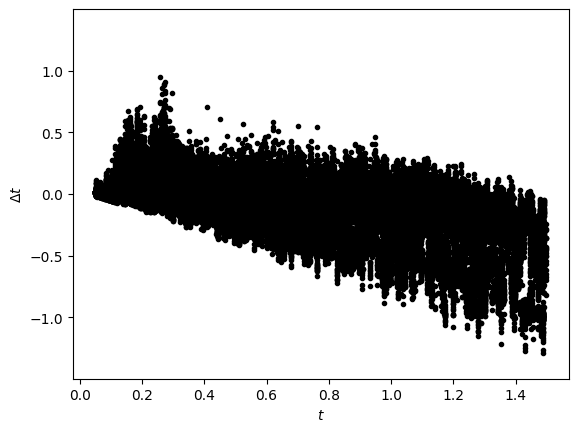

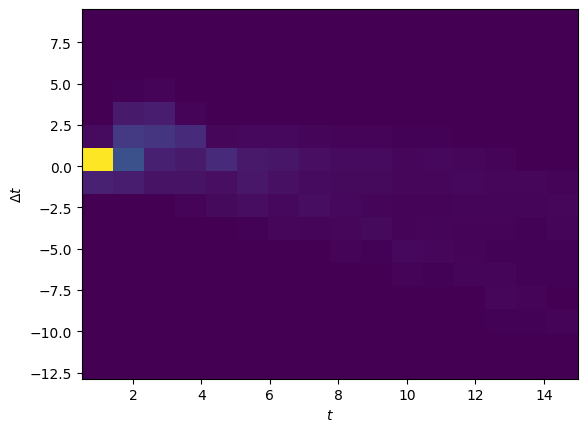

In [58]:
axs = (1, 1)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k.')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

plx = p[:, axs[0]] * 10
ply = res[:, axs[1]] * 10.0
plt.hist2d(plx, ply, bins=16)
#plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_232600/329006640.py:37: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
/tmp/ipykernel_232600/329006640.py:11: UserWarning: Warning: converting a masked element to nan.
  mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])


['z', 'zerr', 'chi2', 'mean_fiber_ra', 'mean_fiber_dec', 'id', 'targetphotid', 'targetid', 'tileid', 'zwarn', 'object_id', 'ra', 'dec', 'g_kronflux_mag', 'g_kronflux_magerr', 'r_kronflux_mag', 'r_kronflux_magerr', 'i_kronflux_mag', 'i_kronflux_magerr', 'z_kronflux_mag', 'z_kronflux_magerr', 'y_kronflux_mag', 'y_kronflux_magerr', 'Separation']
tf.Tensor([nan nan nan], shape=(3,), dtype=float32) 0.8578496837263326
[np.float64(0.8578496837263326), np.float64(0.2904546610270198), np.float64(0.7854575867277388), np.float64(0.822681493570212), np.float64(0.7853066054030228), np.float64(0.7895841837901794), np.float64(0.8548200914797005), np.float64(0.8158084245673792), np.float64(0.45061105141443), np.float64(0.3666860000698166)]


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_17']
Received: inputs=Tensor(shape=(129135, 5))
  warnings.warn(msg)


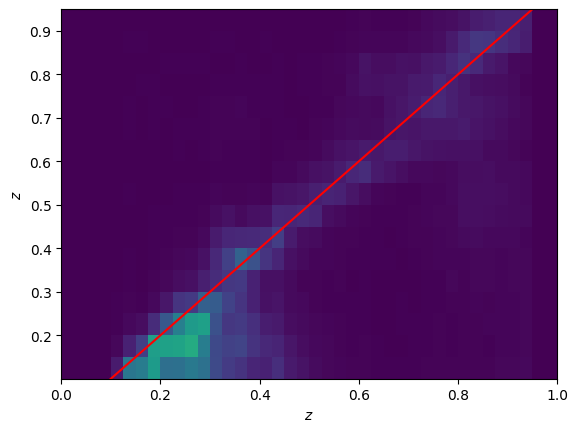

In [59]:
t_hsc_ = Table.read('DESI_DR1_HSCSSP_clean_v2.fits')
     

hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0))]

print(t_hsc.colnames)

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvaeuse(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p

print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]

print(plx[:10])

plt.hist2d(plx, ply, range=[[0, 1], [-1, 1]], bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
filename = f"plot_dz_beta{beta}_epochs{epochs}_latent{latent_dim}.png"
filename = os.path.join(fig_path, filename)
plt.savefig(filename)
mlflow.log_artifact(filename, artifact_path="plots")

plx = p[:]
ply = res[:]
plt.hist2d(p[:], s[:, 0], range=[[0, 1], [-1, 1]], bins=40)
plt.plot([0, 1], [0, 1], color='red')
plt.ylim(np.min(p[:]), np.max(p[:]))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$ ' + pnames[axs[1]] + '$')
filename = f"plot_zz_beta{beta}_epochs{epochs}_latent{latent_dim}.png"
filename = os.path.join(fig_path, filename)
plt.savefig(filename)
mlflow.log_artifact(filename, artifact_path="plots")

t_hsc['z_photo'] = s[:, 0]



<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:28: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_232600/3765771481.py:28: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
/tmp/ipykernel_232600/3765771481.py:6: UserWarning: Warning: converting a masked element to nan.
  mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])


tf.Tensor([nan nan nan], shape=(3,), dtype=float32) 0.8578496837263326


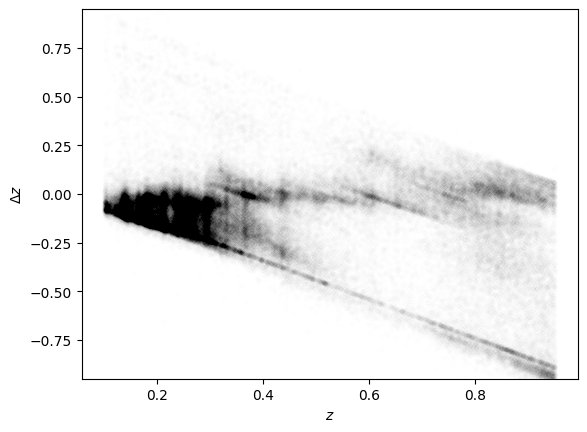

In [60]:
hsc_int = []
hsz_z = []
t_hsc = t_hsc_[((t_hsc_['z'] > 0.1) & (t_hsc_['z'] < 0.95) & (t_hsc_['zwarn'] == 0))]

for r in t_hsc:
    mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
    bandfl = 10**(-0.4*mags)
    bandfl /= np.max(bandfl)
    hsc_int.append(bandfl)
    hsz_z.append(r['z'])

n = len(hsc_int)
pnames = ['z', 't', '[Z/H]']

s = parvaeuse(np.reshape(hsc_int[:n], (n,5)))
p = hsz_z[:n]

res = s[:, 0] - p
print(s[0], p[0])
axs = (0, 0)


plx = p[:]
ply = res[:]
plt.plot(plx, ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()
t_hsc['z_photo'] = s[:, 0]

In [ ]:
plx = np.array(p[:])
ply = np.array(res[:])
print(plx)
# Set number of bins
N = 20  # You can change this to whatever number of bins you want

# Digitize plx into N bins
bins = np.linspace(np.min(plx), np.max(plx), N + 1)
indices = np.digitize(plx, bins)

# Subtract median ply in each bin
corrected_ply = ply
for i in range(1, N + 1):
    bin_mask = indices == i
    if np.any(bin_mask):
        median_val = np.median(ply[bin_mask])
        corrected_ply[bin_mask] -= median_val

# Plot the corrected data
plt.plot(plx, corrected_ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$ (median subtracted)')
plt.show()

plt.hist2d(plx, ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()


from astropy.stats import sigma_clip


N = 20

# Digitize plx into N bins
bins = np.linspace(np.min(plx), np.max(plx), N + 1)
indices = np.digitize(plx, bins)

# Subtract sigma-clipped mean of ply in each bin
corrected_ply = ply.copy()
for i in range(1, N + 1):
    bin_mask = indices == i
    if np.any(bin_mask):
        clipped = sigma_clip(ply[bin_mask], sigma=2.5, maxiters=20)
        mean_val = np.median(clipped.data[~clipped.mask])
        print(np.mean(plx[bin_mask]), mean_val)
        corrected_ply[bin_mask] -= mean_val

# Plot the corrected data
plt.plot(plx, corrected_ply, marker='.', color='black', linestyle='None', alpha=0.005)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()

# 2D histogram
plt.hist2d(plx, corrected_ply, bins=40)
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.colorbar(label='Counts')
plt.show()


34.646902022999356 -1.4101822701929754
[20.771496 19.499832 18.983864 18.680294 18.475664] [0.00637912 0.00253034 0.00162245 0.00221111 0.00382917]
[ 0.72953564  0.29827373 -0.04922333]


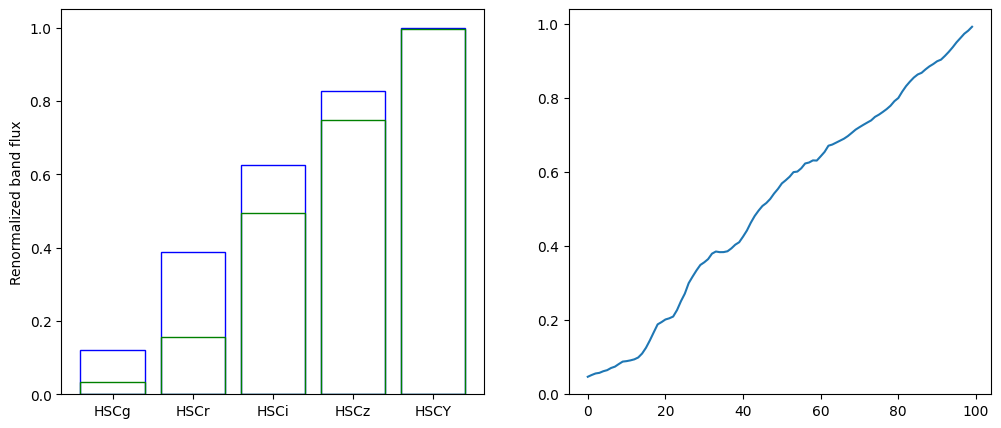

ValueError: Input 0 of layer "cnn_encoder" is incompatible with the layer: expected shape=(None, 100, 1), found shape=(1, 5)

In [61]:
r = t_hsc[t_hsc['targetid'] == 39627749068903312][0]

ii = 50500

print(r['ra'], r['dec'])

mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
mags_err = np.array([r['g_kronflux_magerr'], r['r_kronflux_magerr'], r['i_kronflux_magerr'], r['z_kronflux_magerr'], r['y_kronflux_magerr']])

print(mags, mags_err)

bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

print(params[ii])

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
#axs[1].plot(wllr, spectra[ii], label="true spectrum")
#s = bpvae(np.reshape(bandfl, (1,5)))
#s = np.reshape(s[0].numpy(),(100,))
#axs[1].plot(wllr, s, label="spectrum from bandpasses")
#axs[1].set_xlabel('Wavelength, A')
axs[0].bar(filer_names, bandfl, fill=False, edgecolor='blue')
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')
#fig.suptitle('z = %.2f' % (params[ii, 0]))

s = bpvae(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)
#plt.legend()
plt.show()

p_ls = parvae.apply(np.reshape(bandfl, (1,5)))


p = parvae(np.reshape(bandfl, (1,5)))

print(p_ls)

param_evals = []

nsmpl = 1000
for i in range(nsmpl):
    p_ls = parvae(np.reshape(bandfl, (1,5)))
    param_evals.append(p_ls[0].numpy())

param_evals = np.array(param_evals)
plt.hist(param_evals[:, 0])
plt.axvline(r['z'])

plt.show()


plt.hist2d(param_evals[:, 0], param_evals[:, 1])
plt.show()

plt.plot(param_evals[:, 0], param_evals[:, 1], 'k+')
plt.show()

RA, Dec: 35.349727676882964 1.7417466027924386
Input Magnitudes: [19.97831  19.457182 19.020638 18.94626  18.81935 ]
Magnitude Errors: [0.00189602 0.00180373 0.0013963  0.00258375 0.00410256]


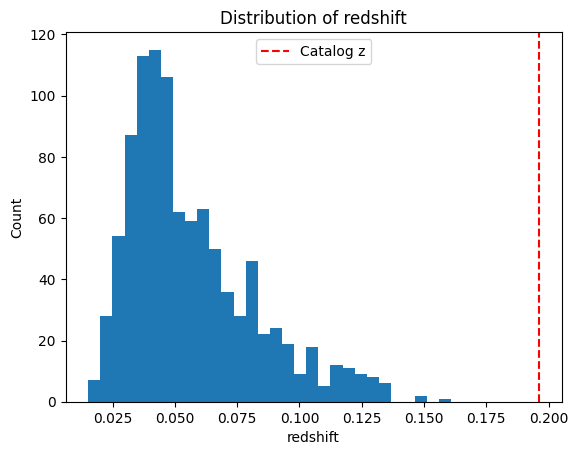

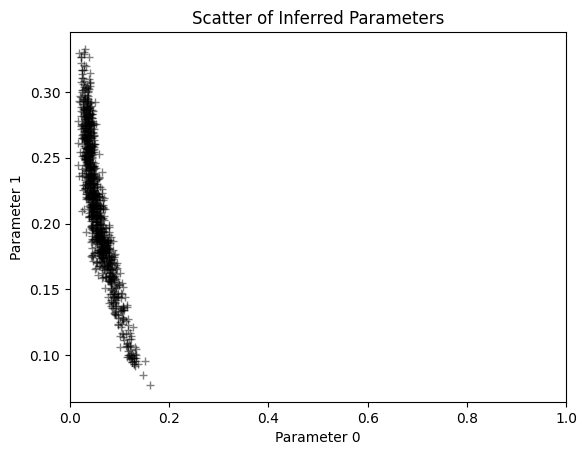

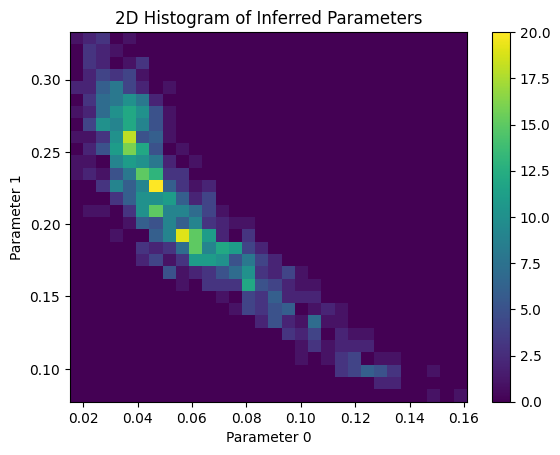

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
target_id = 39627827598855683
nsmpl_lat = 1000

# Extract data for target
r = t_hsc[t_hsc['targetid'] == target_id][0]
print("RA, Dec:", r['ra'], r['dec'])

# Extract magnitudes and errors
mag_keys = ['g_kronflux_mag', 'r_kronflux_mag', 'i_kronflux_mag', 'z_kronflux_mag', 'y_kronflux_mag']
magerr_keys = [k + 'err' for k in mag_keys]

mags = np.array([r[k] for k in mag_keys])
mags_err = np.array([r[k] for k in magerr_keys])

print("Input Magnitudes:", mags)
print("Magnitude Errors:", mags_err)

# Sample different magnitudes
mag_samples = np.random.normal(loc=mags, scale=mags_err, size=(nsmpl_lat, len(mags)))

# Convert magnitudes to normalized fluxes
bandfl_samples = 10**(-0.4 * mag_samples)
bandfl_samples /= np.max(bandfl_samples, axis=1)[:, None]  # normalize per sample

# Apply parvae to each sample
param_evals = []
for i in range(nsmpl_lat):
    band_input = np.reshape(bandfl_samples[i], (1, -1))
    p = parvaeuse(band_input)
    param_evals.append(p[0].numpy())

param_evals = np.array(param_evals)

# Plot: 1D Histogram of First Parameter (e.g., redshift)
plt.hist(param_evals[:, 0], bins=30)
plt.axvline(r['z'], color='r', linestyle='--', label='Catalog z')
plt.xlabel("redshift")
plt.ylabel("Count")
plt.title("Distribution of redshift")
plt.legend()
plt.show()

# Plot: 2D Scatter of First Two Parameters
plt.plot(param_evals[:, 0], param_evals[:, 1], 'k+', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")
plt.title("Scatter of Inferred Parameters")
plt.show()

# Plot: 2D Histogram
plt.hist2d(param_evals[:, 0], param_evals[:, 1], bins=30)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")
plt.title("2D Histogram of Inferred Parameters")
plt.colorbar()
plt.show()

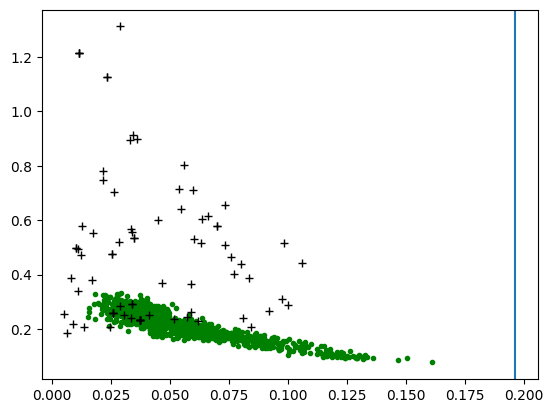

In [64]:
mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
bandfl = 10**(-0.4*mags)

bandfl /= np.max(bandfl)

rall = np.sum((integrals - bandfl)**2, axis=-1)

idx = np.where(rall < 5*0.025**2)[0]

p_v = params[idx]

plt.plot(param_evals[:, 0], param_evals[:, 1], 'g.')

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.axvline(r['z'])
#plt.axhline(r['ssp_age']/1e4)

plt.show()

[5700 5700 5700 5701 5701 5701 5702 5702 5702 5703 5703 5703 5704 5704
 5704 5705 5705 5705 5706 5706 5706 5707 5707 5707 5708 5708 5708 5709
 5709 5709 5710 5710 5710 5711 5711 5711 5712 5712 5712 5713 5713 5713
 5714 5714 5714 5715 5715 5715 5716 5716 5716 5717 5717 5717 5718 5718
 5718 5719 5719 5719]
[ 0.71499743  0.15794522 -0.06429962]


ValueError: cannot reshape array of size 3 into shape (100,)

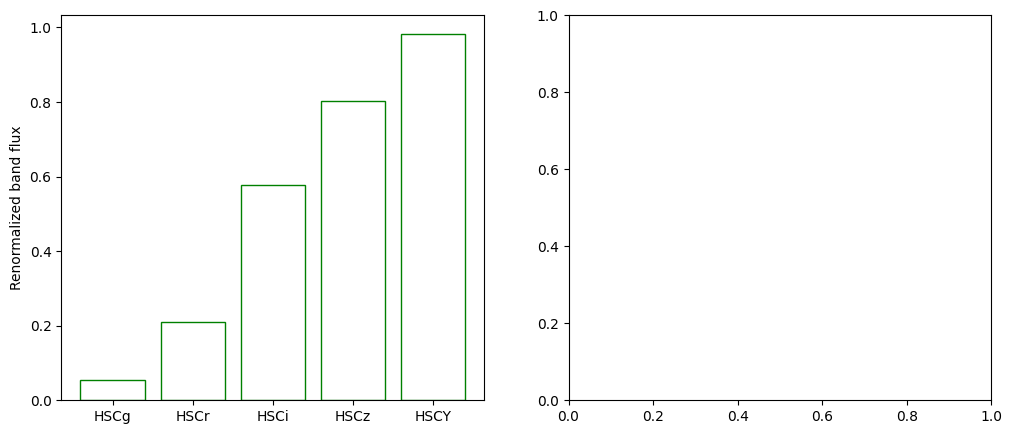

In [68]:
ii = 5700

bandfl = integrals[ii]

idx_same_smpl = np.where(params == params[ii])[0]
print(idx_same_smpl)


nsmpl = 10
p_est = []
for idx_sm_ in idx_same_smpl:
    for i in range(nsmpl):
        p_estls = parvaeuse(np.reshape(integrals[idx_sm_], (1,5)))
        p_est.append(p_estls[0].numpy())

p_est = np.array(p_est)

p0 = params[ii]

print(p0)


fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)
axs[0].bar(filer_names, integrals[ii], fill=False, edgecolor='green')
axs[0].set_ylabel('Renormalized band flux')

s = parvaeuse(np.reshape(bandfl, (1,5)))
s = np.reshape(s[0].numpy(),(100,))
axs[1].plot(s)
plt.show()




rall = np.sum((integrals - bandfl)**2, axis=-1)

idx = np.where(rall < 5*0.006**2)[0]


p_v = params[idx]

plt.plot(p_est[:, 0], p_est[:, 1], 'g.')

plt.plot(p_v[:, 0], p_v[:, 1], 'k+')
plt.axvline(p0[0])
plt.axhline(p0[1])

plt.show()

